Изображение загружено: (300, 400)


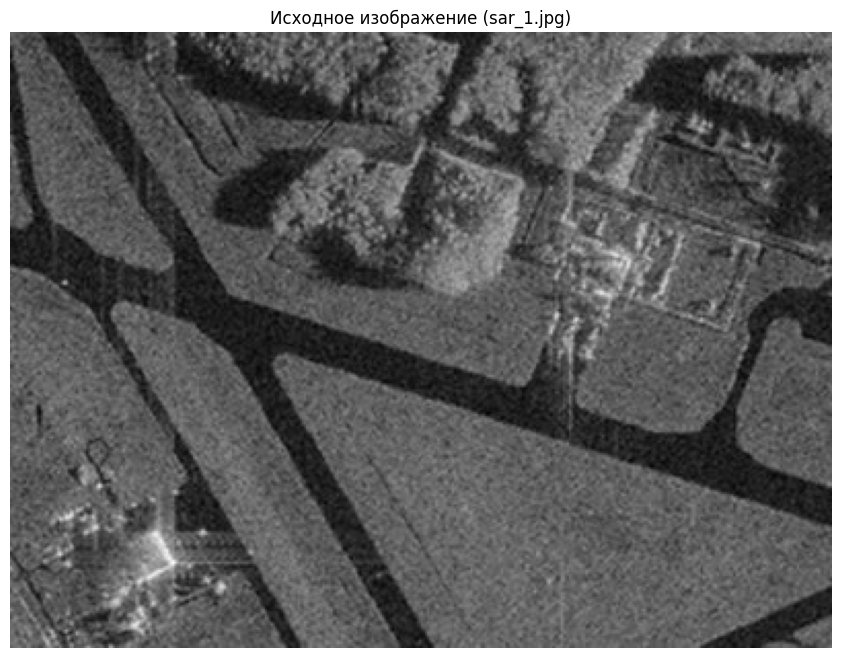

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

# Загрузка первого изображения
image_path_1 = 'sar_1.jpg'
img_color = cv2.imread(image_path_1)

if img_color is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение: {image_path_1}")

img_gray = cv2.cvtColor(img_color, cv2.COLOR_BGR2GRAY)

print(f"Изображение загружено: {img_gray.shape}")
plt.imshow(img_gray, cmap="gray")
plt.title("Исходное изображение (sar_1.jpg)")
plt.axis('off')
plt.show()


In [2]:
def check_homogeneity(image_array, current_mask, target_point, threshold_val):
    """
    Проверяет, является ли пиксель однородным с регионом

    Параметры:
    image_array -- исходное изображение
    current_mask -- текущая маска региона
    target_point -- проверяемая точка (y, x)
    threshold_val -- пороговое значение
    """
    region_values = image_array[current_mask > 0]
    if len(region_values) == 0:
        return False

    region_average = np.mean(region_values)
    pixel_value = image_array[target_point]

    return abs(region_average - pixel_value) <= threshold_val

In [3]:
def perform_region_growth(input_image, start_point, homogeneity_func, radius, tolerance):
    """
    Выполняет регионарный рост из начальной точки

    Параметры:
    input_image -- входное изображение
    start_point -- начальная точка (y, x)
    homogeneity_func -- функция проверки однородности
    radius -- радиус окрестности
    tolerance -- допуск по интенсивности
    """
    height, width = input_image.shape
    region_mask = np.zeros_like(input_image, dtype=np.uint8)
    region_mask[start_point] = 1

    iteration_count = 0
    has_changes = True

    while has_changes:
        has_changes = False
        new_pixels = np.zeros_like(region_mask, dtype=np.uint8)

        # Проверяем граничные пиксели
        for y in range(radius, height - radius):
            for x in range(radius, width - radius):
                if region_mask[y, x] == 0:
                    # Проверяем, есть ли сосед в регионе
                    neighborhood = region_mask[y-radius:y+radius+1, x-radius:x+radius+1]
                    if np.any(neighborhood > 0):
                        if homogeneity_func(input_image, region_mask, (y, x), tolerance):
                            new_pixels[y, x] = 1
                            has_changes = True

        if has_changes:
            region_mask = np.logical_or(region_mask, new_pixels).astype(np.uint8)
            iteration_count += 1
            print(f"Итерация {iteration_count}: добавлено {np.sum(new_pixels)} пикселей")

    return region_mask * 255

Итерация 1: добавлено 48 пикселей
Итерация 2: добавлено 119 пикселей
Итерация 3: добавлено 192 пикселей
Итерация 4: добавлено 264 пикселей
Итерация 5: добавлено 331 пикселей
Итерация 6: добавлено 401 пикселей
Итерация 7: добавлено 478 пикселей
Итерация 8: добавлено 550 пикселей
Итерация 9: добавлено 620 пикселей
Итерация 10: добавлено 685 пикселей
Итерация 11: добавлено 766 пикселей
Итерация 12: добавлено 836 пикселей
Итерация 13: добавлено 905 пикселей
Итерация 14: добавлено 979 пикселей
Итерация 15: добавлено 1049 пикселей
Итерация 16: добавлено 857 пикселей
Итерация 17: добавлено 736 пикселей
Итерация 18: добавлено 713 пикселей
Итерация 19: добавлено 683 пикселей
Итерация 20: добавлено 657 пикселей
Итерация 21: добавлено 628 пикселей
Итерация 22: добавлено 603 пикселей
Итерация 23: добавлено 573 пикселей
Итерация 24: добавлено 570 пикселей
Итерация 25: добавлено 508 пикселей
Итерация 26: добавлено 487 пикселей
Итерация 27: добавлено 460 пикселей
Итерация 28: добавлено 432 пикселей
И

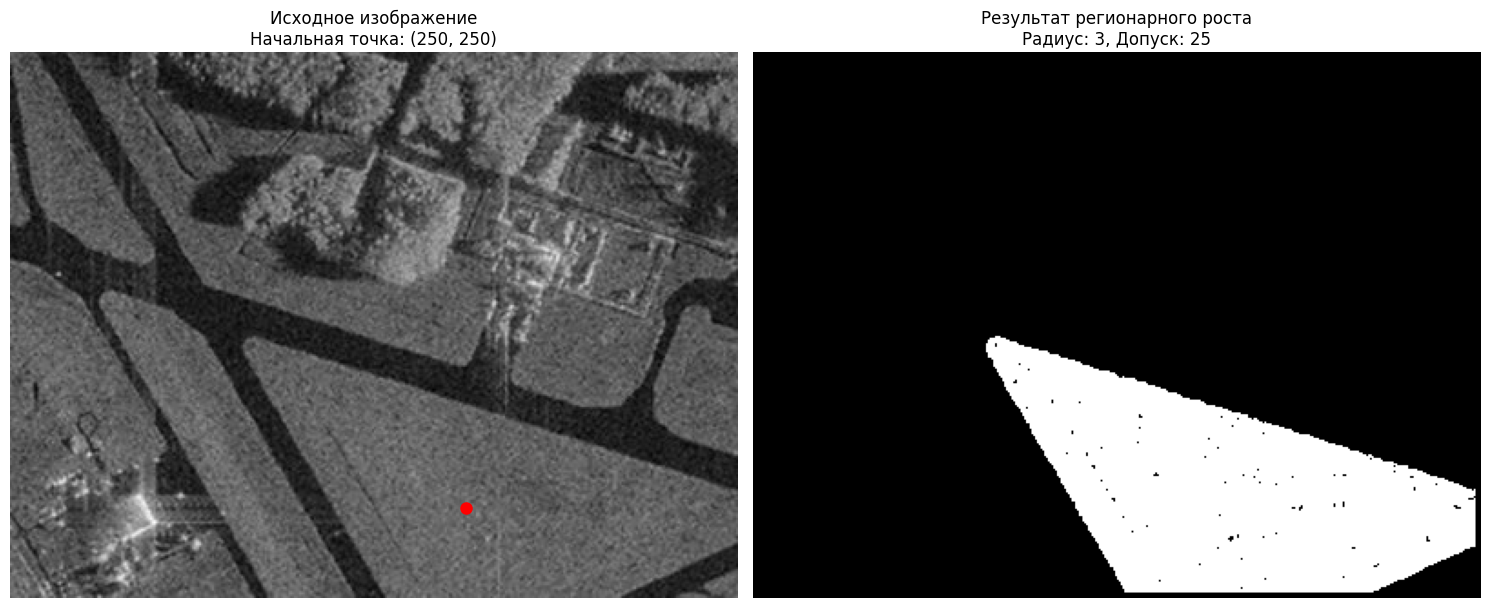

In [4]:
initial_point = (250, 250)
neighborhood_radius = 3
intensity_tolerance = 25

segmented_region = perform_region_growth(
    img_gray,
    initial_point,
    check_homogeneity,
    neighborhood_radius,
    intensity_tolerance
)

# Визуализация результата
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].imshow(img_gray, cmap="gray")
axes[0].plot(initial_point[1], initial_point[0], 'ro', markersize=8)
axes[0].set_title(f"Исходное изображение\nНачальная точка: {initial_point}")
axes[0].axis('off')

axes[1].imshow(segmented_region, cmap="gray")
axes[1].set_title(f"Результат регионарного роста\nРадиус: {neighborhood_radius}, Допуск: {intensity_tolerance}")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [5]:
def apply_kmeans_clustering(image_data, num_clusters, max_iterations, epsilon_value):
    """
    Применяет K-means кластеризацию к изображению
    """
    pixel_values = image_data.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    clustering_criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        max_iterations,
        epsilon_value
    )

    _, labels, centers = cv2.kmeans(
        pixel_values,
        num_clusters,
        None,
        clustering_criteria,
        10,
        cv2.KMEANS_RANDOM_CENTERS
    )

    centers = np.uint8(centers)
    segmented_image = centers[labels.flatten()]
    return segmented_image.reshape(image_data.shape)

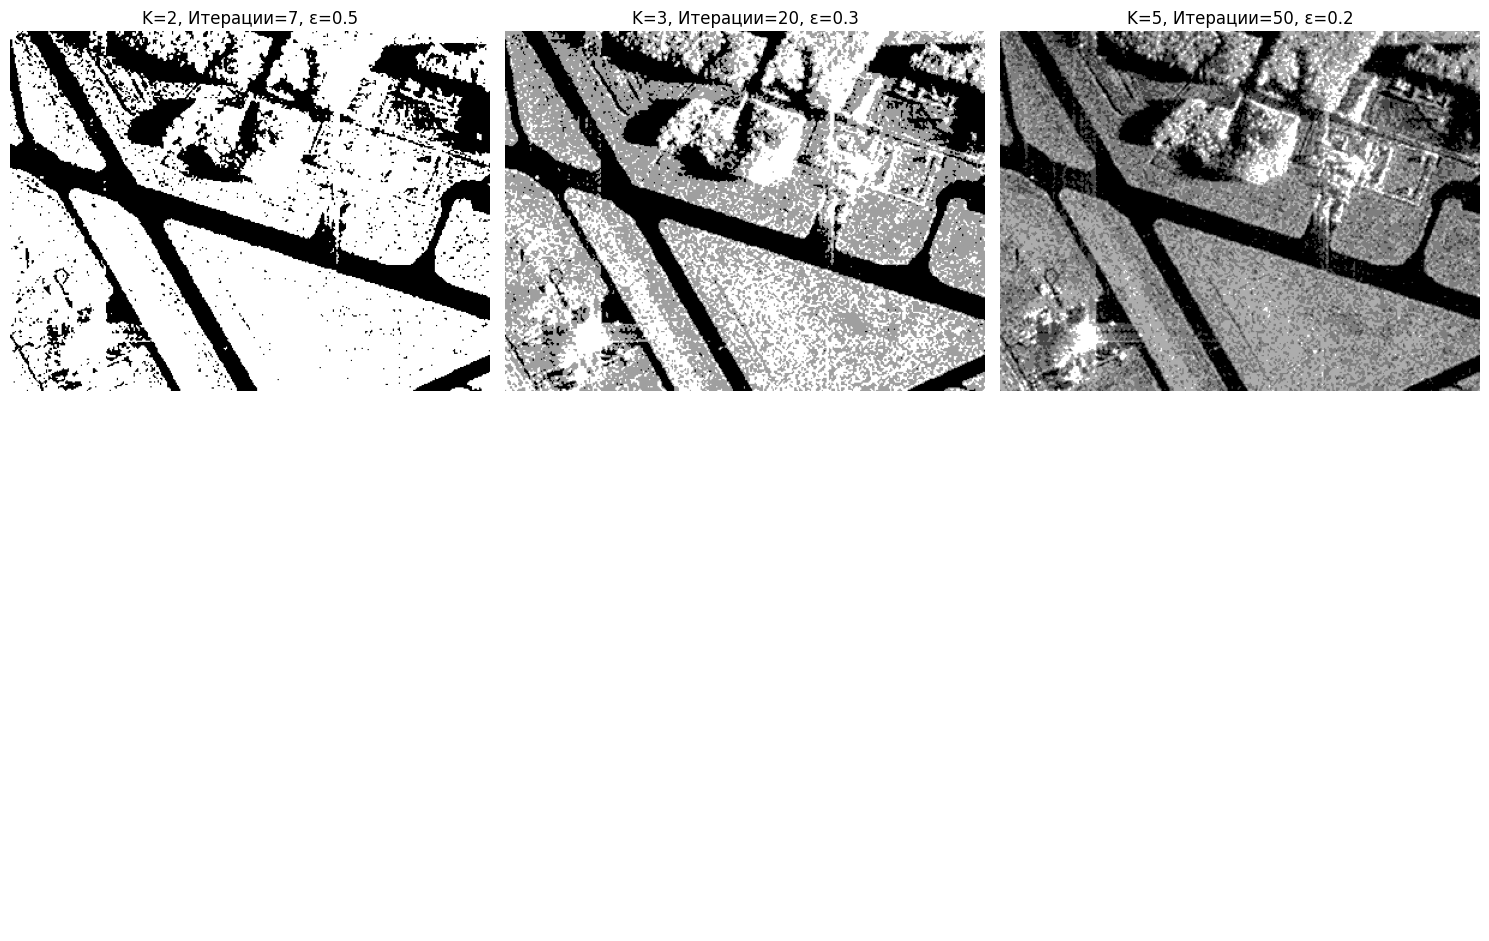

In [6]:
k_values = [2, 3, 5]
iter_params = [7, 20, 50]
epsilon_params = [0.5, 0.3, 0.2]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, (k, max_iter, epsilon) in enumerate(zip(k_values, iter_params, epsilon_params)):
    row = idx // 3
    col = idx % 3

    kmeans_result = apply_kmeans_clustering(img_color, k, max_iter, epsilon)
    kmeans_gray = cv2.cvtColor(kmeans_result, cv2.COLOR_BGR2GRAY)

    axes[row, col].imshow(kmeans_gray, cmap="gray")
    axes[row, col].set_title(f"K={k}, Итерации={max_iter}, ε={epsilon}")
    axes[row, col].axis('off')

# Скрываем пустые subplots
for idx in range(len(k_values), 6):
    row = idx // 3
    col = idx % 3
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Изображение пальм загружено: (527, 535)


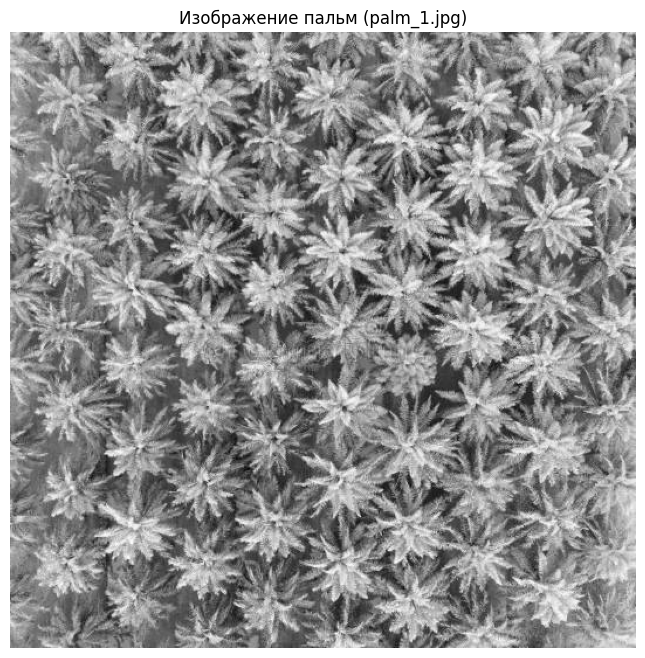

In [7]:
image_path_2 = 'palm_1.jpg'
palm_image = cv2.imread(image_path_2)

if palm_image is None:
    raise FileNotFoundError(f"Не удалось загрузить изображение: {image_path_2}")

palm_gray = cv2.cvtColor(palm_image, cv2.COLOR_BGR2GRAY)

print(f"Изображение пальм загружено: {palm_gray.shape}")
plt.imshow(palm_gray, cmap="gray")
plt.title("Изображение пальм (palm_1.jpg)")
plt.axis('off')
plt.show()

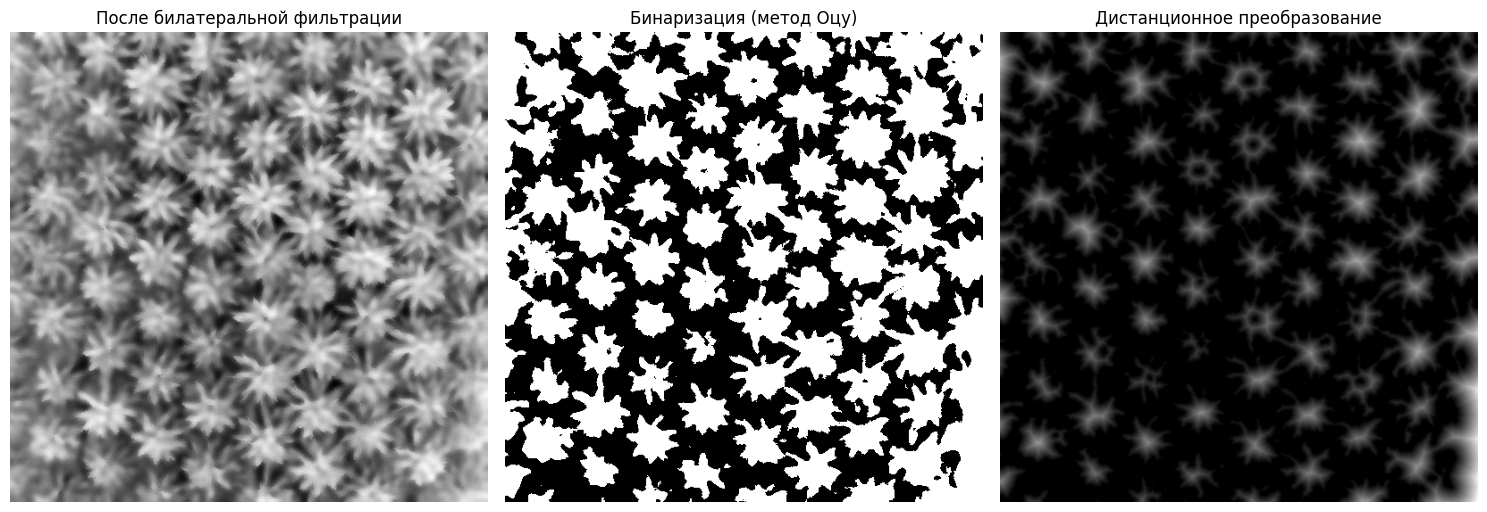

In [8]:

filtered_palm = cv2.bilateralFilter(palm_gray, d=11, sigmaColor=75, sigmaSpace=75)

_, binary_mask = cv2.threshold(filtered_palm, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(filtered_palm, cmap="gray")
axes[0].set_title("После билатеральной фильтрации")
axes[0].axis('off')

axes[1].imshow(binary_mask, cmap="gray")
axes[1].set_title("Бинаризация (метод Оцу)")
axes[1].axis('off')

distance_transform = cv2.distanceTransform(binary_mask, cv2.DIST_L2, 5)
distance_display = cv2.normalize(distance_transform, None, 0, 1.0, cv2.NORM_MINMAX)

axes[2].imshow(distance_display, cmap="gray")
axes[2].set_title("Дистанционное преобразование")
axes[2].axis('off')

plt.tight_layout()
plt.show()

Найдено компонентов: 100


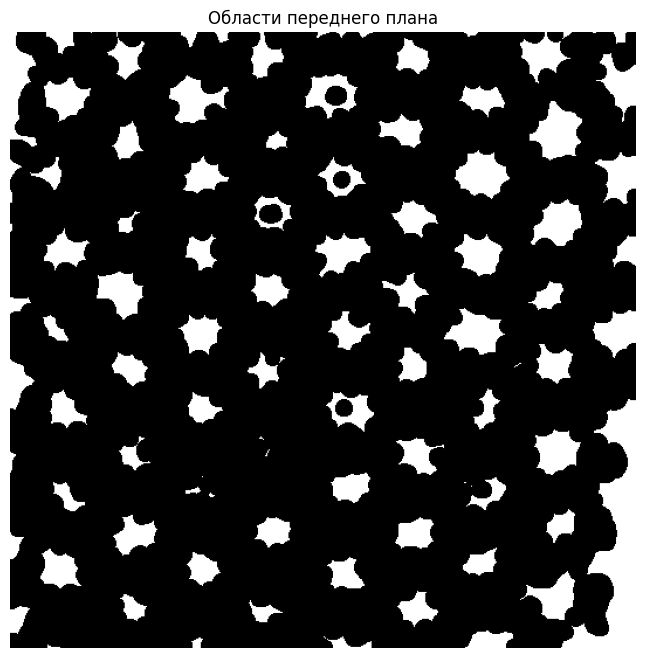

In [9]:
foreground_threshold = 0.2
_, sure_foreground = cv2.threshold(
    distance_transform,
    foreground_threshold * distance_transform.max(),
    255,
    cv2.THRESH_BINARY
)

sure_foreground = sure_foreground.astype(np.uint8)

num_components, markers = cv2.connectedComponents(sure_foreground)

print(f"Найдено компонентов: {num_components}")

plt.imshow(sure_foreground, cmap="gray")
plt.title("Области переднего плана")
plt.axis('off')
plt.show()

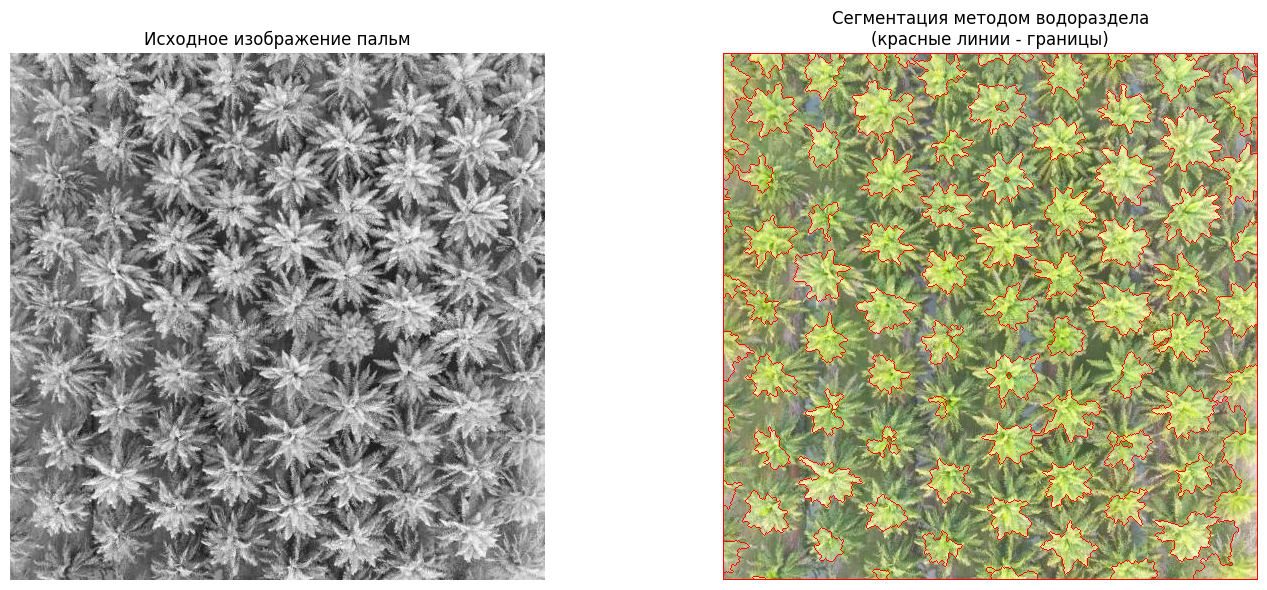

In [10]:
# Увеличиваем маркеры на 1 (watershed требует, чтобы фон был 1)
markers = markers + 1

# Помечаем неизвестную область как 0
unknown_area = cv2.subtract(binary_mask, sure_foreground)
markers[unknown_area == 255] = 0

# Применяем watershed
palm_image_rgb = cv2.cvtColor(palm_image, cv2.COLOR_BGR2RGB)
markers = cv2.watershed(palm_image_rgb, markers)

# Размечаем границы
palm_image_rgb[markers == -1] = [255, 0, 0]  # Красный для границ

# Визуализация результата
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

axes[0].imshow(palm_gray, cmap="gray")
axes[0].set_title("Исходное изображение пальм")
axes[0].axis('off')

axes[1].imshow(palm_image_rgb)
axes[1].set_title("Сегментация методом водораздела\n(красные линии - границы)")
axes[1].axis('off')

plt.tight_layout()
plt.show()

РЕЗУЛЬТАТЫ СЕГМЕНТАЦИИ ПАЛЬМ
Общее количество маркеров: 100
Уникальных регионов: 98
Количество пальм: 97


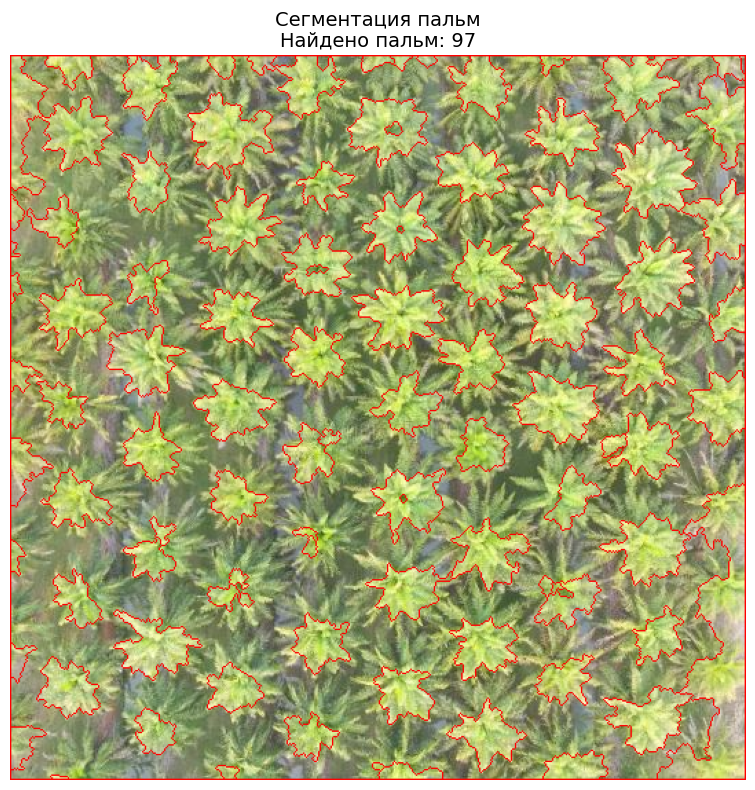

In [11]:
# Исключаем фон (метка 1) и границы (метка -1)
valid_markers = markers.copy()
valid_markers[valid_markers == 1] = 0  # Игнорируем фон
valid_markers[valid_markers == -1] = 0  # Игнорируем границы

unique_regions = np.unique(valid_markers)
palms_count = len(unique_regions) - 1  # Минус 0 (игнорированные)

print("=" * 50)
print("РЕЗУЛЬТАТЫ СЕГМЕНТАЦИИ ПАЛЬМ")
print("=" * 50)
print(f"Общее количество маркеров: {num_components}")
print(f"Уникальных регионов: {len(unique_regions)}")
print(f"Количество пальм: {palms_count}")
print("=" * 50)

# Визуализация с подписью
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(palm_image_rgb)
ax.set_title(f"Сегментация пальм\nНайдено пальм: {palms_count}", fontsize=14)
ax.axis('off')

plt.tight_layout()
plt.show()